In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls

In [2]:
##Set data library
dl = DataLib("SignalData")

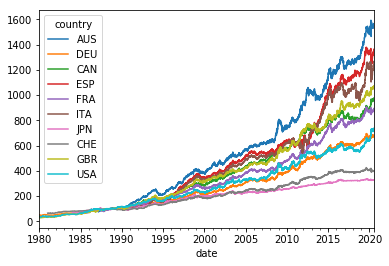

In [3]:
##Bond Returns Index in Local FX
bondRetIdx = dl.pull("BondRetIdx/LocalFX")
bondRetIdx.plot()
plt.show()

##Definition: Total return index of 10 year government issued bonds.
##Additional Info: Article on what an index is: https://www.dallasfed.org/research/basics/indexing.aspx
##                 A total return index (as opposed to a price index, which accounts for just price changes) accounts for all return streams generated by the underlying components (coupon payments, for instance)

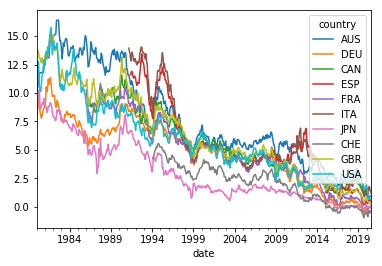

In [4]:
##Long Rates
longRates = dl.pull("LongRates")
longRates.plot()
plt.show()

##Definition: Nominal yield on 10-year govenment issued bonds
##Addition info: Real vs nominal yields: https://www.investopedia.com/ask/answers/032515/what-difference-between-real-and-nominal-interest-rates.asp#:~:text=A%20real%20interest%20rate%20is,before%20taking%20inflation%20into%20account.

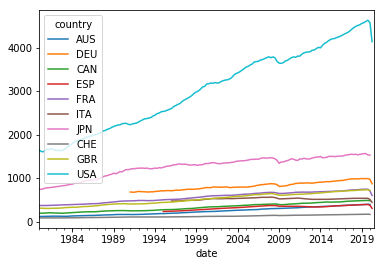

In [5]:
##GDP Real
gdpReal = dl.pull("GDP/Real")
gdpReal.plot()
plt.show()

##Definition: Real gross domestic product (GDP) is an inflation-adjusted measure that reflects the value of all goods and services produced by an economy in a given year (expressed in base-year prices) and is often referred to as "constant-price," "inflation-corrected", or "constant dollar" GDP.

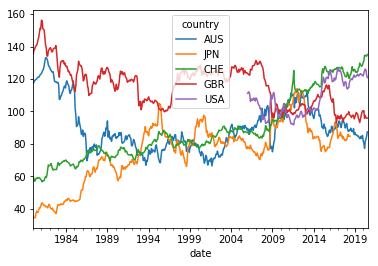

In [6]:
##FX (Trade Weighted Basket of Currencies)
fxTrdWts = dl.pull("fxTrdWts/Nominal")
fxTrdWts.plot()
plt.show()

##Definition: A trade-weighted currency index is a weighted average of a basket of currencies that reflects the importance of a country's trade (imports and exports) with these countries. Sometimes a trade-weighted currency index is taken as a crude measure of a country's international "competitiveness". At any rate, a trade-weighted currency index is a useful measure to aggregate diverging trends among currencies of a country's trading partners.

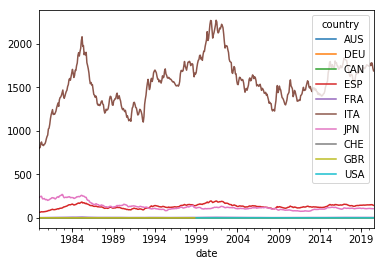

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,1.5862,1.8006,1.4058,153.1831,6.0391,1782.626,107.7285,0.9710,1.2410,1.0934
2020-05,1.5353,1.7940,1.3970,152.6218,6.0169,1776.093,107.2668,0.9707,1.2300,1.1107
2020-06,1.4494,1.7378,1.3550,147.8383,5.8284,1720.427,107.6050,0.9511,1.2526,1.1237
2020-07,1.4213,1.7062,1.3499,145.1455,5.7222,1689.090,106.7357,0.9346,1.2691,1.1635
2020-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
##FX vs USD
fxVsUSD = dl.pull("fxVsUSD")
fxVsUSD.plot()
plt.show()

##Definition: Exchange rate with USD. The US code here, in confusingly a USD vs EUR exchange rate. I think you can mostly ignore it. For european monetary union countries, the construction takes
##the pre-euro currency exchange rate (e.g., lira in Italy) and then extends the exchange rate forward after 1999 with changes in the USD/EUR exchange rate. This concept is mostly useful in change space

##Additionally, the convention of the ratio given currX/USD or USD/currX is a little different across currencies.
fxVsUSD.tail()
##AUS: 1 USD gets you 1.42 Australian dollars
##DEU: 1 USD gets you 1.7 deutschemarks (extended forward with euro changes)
##CAN: 1 USD gets you 1.35 Canadian dollars
##ESP: 1 USD gets you 143 pesetas (extended forward with euro changes)
##FRA: 1 USD gets you 5.7 French francs (extended forward with euro changes)
##ITA: 1 USD gets you 1689 lira (extended forward with euro changes)
##JPN: 1 USD gets you 106.7 yen
##CHE: 1 USD gets you 0.93 Swiss francs
##GBR: 1.27 USD gets you 1 pound sterling
##USA: 1.16 USD gets you 1 euro

In [111]:
# Real GDP relative to the world average

###### Resample the Bond Return Index by Quarter
bondRetIdxQuarterly = bondRetIdx.resample('1Q').mean()

###### Create the rolling 1 quarter returns
bondRetIdxQuarterlyReturns = bondRetIdxQuarterly.pct_change()[1:]

###### Create the rolling 1 quarter returns
gdpRealReturns = gdpReal.pct_change()[1:]

# gdpRealReturnsZScore = (gdpRealReturns - gdpRealReturns.mean())/gdpRealReturns.std()
gdpRealReturnsZScore = (gdpRealReturns - gdpRealReturns.rolling(window = 40, min_periods = 40).mean()) / gdpRealReturns.rolling(window = 40, min_periods = 1).std()


###### Unweighted Strategy
# Create a simple Unweighted average of gdpRealReturnsZScore for every quarter
globalAveragegdpRealReturnsZScore = gdpRealReturnsZScore.mean(axis=1) 

gdpRealReturnsRelativeZScore = gdpRealReturnsZScore.sub(globalAveragegdpRealReturnsZScore, axis = 'rows')

######################################################################################################
######## Alternate construction by weighting the Real GDP impact of every economy on the global figures
# Expand on the previous model and create a global average based on the GDP of each country
# This allows us to weight each country by the "impact" it has on the global economy

gdpRealTotal = gdpReal.sum(axis = 1)



globalRealGDPShare = gdpReal.div(gdpRealTotal, axis = 0)[1:]


globalWeightedAveragegdpRealReturnsZScore_partial = gdpRealReturnsZScore.mul(globalRealGDPShare)

globalWeightedAveragegdpRealReturnsZScore = globalWeightedAveragegdpRealReturnsZScore_partial.sum(axis = 1)


gdpRealReturnsWeightedRelativeZScore = gdpRealReturnsZScore.sub(globalWeightedAveragegdpRealReturnsZScore, axis = 'rows')

######################################################################################################


###### Create a filter that takes the relative Z scores for each country during each Quarter and
###### computes a signal between -100 (fully short) and 100 (fully long) that we would like to trade on

def position(x):
    if 0 < x <= 0.5:
        return -25
    elif 0.5 < x <= 1:
        return -40
    elif 1 < x <= 2:
        return -70
    elif x > 2:
        return -100
    elif x == 0:
        return 0
    elif x >= -0.5:
        return 25
    elif x >= -1:
        return 40
    elif x >= -2:
        return 70
    else:
        return 100
    
###### The Passive Long Signal would always want us to go long on every single bond throughout all of history
def position_passive_long(x):
    return 100


    

In [112]:
###### Create the Signals
signalRealGDP = gdpRealReturnsRelativeZScore.applymap(lambda x: position(x) if pd.notnull(x) else np.NaN)
signalWeightedRealGDP = gdpRealReturnsWeightedRelativeZScore.applymap(lambda x: position(x) if pd.notnull(x) else np.NaN)
signalPassiveLongRealGDP = gdpRealReturnsWeightedRelativeZScore.applymap(lambda x: position_passive_long(x) if pd.notnull(x) else np.NaN)

print('signalRealGDP')
signalRealGDP.tail()



signalRealGDP


country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,25.0,25.0,25.0,-25.0,25.0,-25.0,25.0,-25.0,-25.0,-25.0
2019Q4,-25.0,-25.0,25.0,-70.0,40.0,-25.0,70.0,-25.0,40.0,-40.0
2020Q1,-70.0,-40.0,25.0,70.0,70.0,70.0,-100.0,40.0,40.0,-25.0
2020Q2,-70.0,100.0,-100.0,100.0,100.0,100.0,-100.0,-100.0,-100.0,100.0
2020Q3,70.0,-25.0,25.0,-25.0,-25.0,-40.0,-25.0,25.0,25.0,-25.0


In [113]:
print('signalWeightedRealGDP')
signalWeightedRealGDP.tail()

signalWeightedRealGDP


country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,25.0,25.0,40.0,-25.0,40.0,25.0,25.0,-25.0,-25.0,-25.0
2019Q4,-25.0,25.0,25.0,-40.0,40.0,-25.0,70.0,-25.0,40.0,-40.0
2020Q1,-70.0,-25.0,40.0,70.0,100.0,70.0,-100.0,70.0,70.0,25.0
2020Q2,-100.0,-25.0,-100.0,-25.0,-25.0,-25.0,-100.0,-100.0,-100.0,25.0
2020Q3,70.0,25.0,40.0,-25.0,-25.0,-25.0,25.0,40.0,40.0,25.0


In [114]:

RealizedReturns = pd.DataFrame(index = bondRetIdxQuarterlyReturns.index, columns = bondRetIdxQuarterlyReturns.columns)
RealizedWeightedReturns = pd.DataFrame(index = bondRetIdxQuarterlyReturns.index, columns = bondRetIdxQuarterlyReturns.columns)
RealizedReturnsPassiveLong = pd.DataFrame(index = bondRetIdxQuarterlyReturns.index, columns = bondRetIdxQuarterlyReturns.columns)


for date_index in range(len(signalRealGDP.index) - 1):
    for country_index in range(len(signalRealGDP.columns)):
        RealizedReturns.iloc[date_index + 1, country_index] = signalRealGDP.iloc[date_index, country_index] * bondRetIdxQuarterlyReturns.iloc[date_index + 1, country_index]


for date_index in range(len(signalWeightedRealGDP.index) - 1):
    for country_index in range(len(signalWeightedRealGDP.columns)):
        RealizedWeightedReturns.iloc[date_index + 1, country_index] = signalWeightedRealGDP.iloc[date_index, country_index] * bondRetIdxQuarterlyReturns.iloc[date_index + 1, country_index]


for date_index in range(len(signalRealGDP.index) - 1):
    for country_index in range(len(signalRealGDP.columns)):
        RealizedReturnsPassiveLong.iloc[date_index + 1, country_index] = signalPassiveLongRealGDP.iloc[date_index, country_index] * bondRetIdxQuarterlyReturns.iloc[date_index + 1, country_index]


###### A Metric for the Total P&L if we had 100 dollars for every country every Quarter and at every Quarter
###### we decided what position to take in each country based on the Signals computed above
TotalHistoricalRealizedReturns = RealizedReturns.expanding(1).sum()
TotalHistoricalRealizedWeightedReturns = RealizedWeightedReturns.expanding(1).sum()
TotalHistoricalRealizedReturnsPassiveLong = RealizedReturnsPassiveLong.expanding(1).sum()


print('Total P&L of Unweighted Strategy = ', TotalHistoricalRealizedReturns.iloc[-1, :].sum())
print('Total P&L of Weighted Strategy = ', TotalHistoricalRealizedWeightedReturns.iloc[-1, :].sum())
print('Total P&L of Passive Long Strategy = ', TotalHistoricalRealizedReturnsPassiveLong.iloc[-1,:].sum())
print('Total P&L of Passive Short Strategy = ', - TotalHistoricalRealizedReturnsPassiveLong.iloc[-1,:].sum())


Total P&L of Unweighted Strategy =  25.835038632928175
Total P&L of Weighted Strategy =  47.3599694032839
Total P&L of Passive Long Strategy =  1732.0929571682775
Total P&L of Passive Short Strategy =  -1732.0929571682775


In [115]:

#########################################################################################################
#########################################################################################################
#########################################################################################################
############ Performance Analysis

OverallPerformanceRealgdp = pd.DataFrame(index = RealizedReturns.index, columns = ['Total P&L', 'Total Money Invested', 'Total Return'])
OverallWeightedPerformanceRealgdp = pd.DataFrame(index = RealizedWeightedReturns.index, columns = ['Total P&L', 'Total Money Invested', 'Total Return'])
OverallPerformanceRealgdpPassiveLong = pd.DataFrame(index = RealizedReturnsPassiveLong.index, columns = ['Total P&L', 'Total Money Invested', 'Total Return'])

OverallPerformanceRealgdp['Total P&L'] = RealizedReturns.sum(axis = 1)
OverallPerformanceRealgdp['Total Money Invested'] = signalRealGDP.T.apply(lambda x: abs(x).sum())


OverallWeightedPerformanceRealgdp['Total P&L'] = RealizedWeightedReturns.sum(axis = 1)
OverallWeightedPerformanceRealgdp['Total Money Invested'] = signalWeightedRealGDP.T.apply(lambda x: abs(x).sum())


OverallPerformanceRealgdpPassiveLong['Total P&L'] = RealizedReturnsPassiveLong.sum(axis = 1)
OverallPerformanceRealgdpPassiveLong['Total Money Invested'] = signalPassiveLongRealGDP.T.apply(lambda x: abs(x).sum())



for i in range(1, len(OverallPerformanceRealgdp.index)):
    OverallPerformanceRealgdp['Total Return'].iloc[i] = OverallPerformanceRealgdp['Total P&L'].iloc[i] / OverallPerformanceRealgdpPassiveLong['Total Money Invested'].iloc[i-1]


for i in range(1, len(OverallWeightedPerformanceRealgdp.index)):
    OverallWeightedPerformanceRealgdp['Total Return'].iloc[i] = OverallWeightedPerformanceRealgdp['Total P&L'].iloc[i] / OverallPerformanceRealgdpPassiveLong['Total Money Invested'].iloc[i-1]

for i in range(1, len(OverallPerformanceRealgdpPassiveLong.index)):
    OverallPerformanceRealgdpPassiveLong['Total Return'].iloc[i] = OverallPerformanceRealgdpPassiveLong['Total P&L'].iloc[i] / OverallPerformanceRealgdpPassiveLong['Total Money Invested'].iloc[i-1]


print('Risk Adjusted Return of the Unweighted Global Portfolio')
print(OverallPerformanceRealgdp['Total Return'].mean() / OverallPerformanceRealgdp['Total Return'].std())


print('Risk Adjusted Return of the Weighted Global Portfolio')
print(OverallWeightedPerformanceRealgdp['Total Return'].mean() / OverallWeightedPerformanceRealgdp['Total Return'].std())



print('Risk Adjusted Return of the Passive Long Portfolio')
print(OverallPerformanceRealgdpPassiveLong['Total Return'].mean() / OverallPerformanceRealgdpPassiveLong['Total Return'].std())


/Users/dimitral/.local/share/virtualenvs/Internship2020-_YMBLlpf/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Users/dimitral/.local/share/virtualenvs/Internship2020-_YMBLlpf/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/dimitral/.local/share/virtualenvs/Internship2020-_YMBLlpf/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


Risk Adjusted Return of the Unweighted Global Portfolio
0.07523862885022624
Risk Adjusted Return of the Weighted Global Portfolio
0.09744786591335876
Risk Adjusted Return of the Passive Long Portfolio
0.7776299985230405


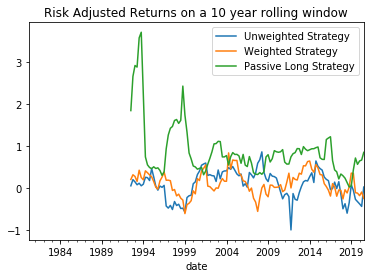

Latest 10 year rolling risk adjusted return for the Unweighted Strategy =  0.020351746188428957
Latest 10 year rolling risk adjusted return for the Weighted Strategy =  -0.2519015103621429
Latest 10 year rolling risk adjusted return for the Passive Long Strategy =  0.850329941797396


In [116]:
###### Create the graphs for rolling 10 year Risk Adjusted Returns
Rolling10YearRiskAdjustedReturn = pd.DataFrame(index = OverallPerformanceRealgdp.index, columns = ['Unweighted Strategy', 'Weighted Strategy', 'Passive Long Strategy'])

Rolling10YearRiskAdjustedReturn['Unweighted Strategy'] = OverallPerformanceRealgdp['Total Return'].rolling(10).mean() / OverallPerformanceRealgdp['Total Return'].rolling(10).std()
Rolling10YearRiskAdjustedReturn['Weighted Strategy'] = OverallWeightedPerformanceRealgdp['Total Return'].rolling(10).mean() / OverallWeightedPerformanceRealgdp['Total Return'].rolling(10).std()
Rolling10YearRiskAdjustedReturn['Passive Long Strategy'] = OverallPerformanceRealgdpPassiveLong['Total Return'].rolling(10).mean() / OverallPerformanceRealgdpPassiveLong['Total Return'].rolling(10).std()


Rolling10YearRiskAdjustedReturn.plot()
plt.title('Risk Adjusted Returns on a 10 year rolling window')
plt.show()

print('Latest 10 year rolling risk adjusted return for the Unweighted Strategy = ', Rolling10YearRiskAdjustedReturn['Unweighted Strategy'][-1])
print('Latest 10 year rolling risk adjusted return for the Weighted Strategy = ', Rolling10YearRiskAdjustedReturn['Weighted Strategy'][-1])
print('Latest 10 year rolling risk adjusted return for the Passive Long Strategy = ', Rolling10YearRiskAdjustedReturn['Passive Long Strategy'][-1])


In [117]:
#########################################################################################################
###### Correlation of Passive Long Strategy to my Strategy
CorrelationReturn = pd.DataFrame({'Unweighted Strategy': OverallPerformanceRealgdp['Total Return'],
                                           'Weighted Strategy': OverallWeightedPerformanceRealgdp['Total Return'],
                                            'Passive Long Strategy': OverallPerformanceRealgdpPassiveLong['Total Return']},
                                           index = OverallPerformanceRealgdp.index)


corr_return = CorrelationReturn.astype(float).corr(method = 'pearson')
# print(corr_return)
print('Correlation of the Unweighted Strategy with the passive long strategy = ', corr_return['Unweighted Strategy']['Passive Long Strategy'])
print('Correlation of the Weighted Strategy with the passive long strategy = ', corr_return['Weighted Strategy']['Passive Long Strategy'])


Correlation of the Unweighted Strategy with the passive long strategy =  -0.235729446227079
Correlation of the Weighted Strategy with the passive long strategy =  -0.26720399773134207


Pearson Correlation of 10 year rolling unweighted, weighted, and passive Return
                       Unweighted Strategy  Weighted Strategy  \
Unweighted Strategy               1.000000           0.000098   
Weighted Strategy                 0.000098           1.000000   
Passive Long Strategy            -0.561508          -0.176458   

                       Passive Long Strategy  
Unweighted Strategy                -0.561508  
Weighted Strategy                  -0.176458  
Passive Long Strategy               1.000000  


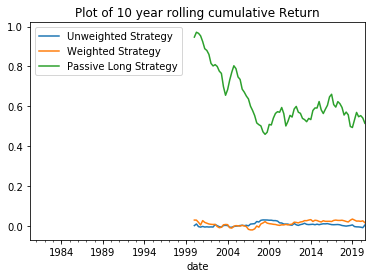

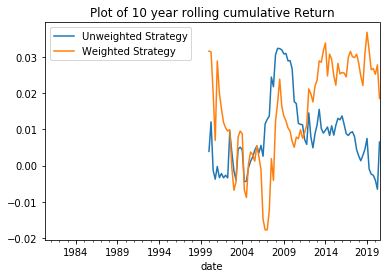

In [118]:
###### 10 year rolling total P&L
CorrelationTenYearRollingReturn = pd.DataFrame({'Unweighted Strategy': OverallPerformanceRealgdp['Total Return'].rolling(40).sum(),
                                               'Weighted Strategy': OverallWeightedPerformanceRealgdp['Total Return'].rolling(40).sum(),
                                               'Passive Long Strategy': OverallPerformanceRealgdpPassiveLong['Total Return'].rolling(40).sum()},
                                               index = OverallPerformanceRealgdp.index)

print('Pearson Correlation of 10 year rolling unweighted, weighted, and passive Return')
print(CorrelationTenYearRollingReturn.astype(float).corr(method = 'pearson'))

CorrelationTenYearRollingReturn.plot()
plt.title('Plot of 10 year rolling cumulative Return')
plt.show()

CorrelationTenYearRollingReturn.loc[:, ['Unweighted Strategy', 'Weighted Strategy']].plot()
plt.title('Plot of 10 year rolling cumulative Return')
plt.show()



country                  AUS     DEU     CAN     ESP     FRA     ITA     JPN  \
Sum of Signal Values  4770.0  2710.0  4470.0  2685.0  4155.0  1940.0  5100.0   

country                  CHE     GBR     USA  
Sum of Signal Values  4425.0  4305.0  4380.0  


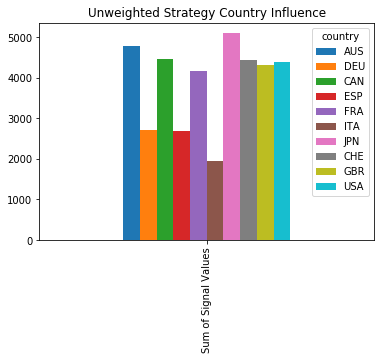

country                  AUS     DEU     CAN     ESP     FRA     ITA     JPN  \
Sum of Signal Values  5010.0  2860.0  4650.0  2595.0  4440.0  1985.0  4875.0   

country                  CHE     GBR     USA  
Sum of Signal Values  4875.0  4470.0  3780.0  


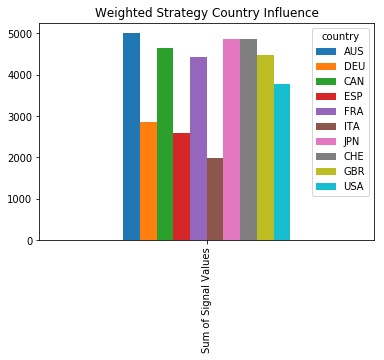

In [119]:
###### Sanity Check to see whether any one country dominates the index
###### For each country we sum up the absolute values of the Signal

UnweightedStrategySignalperCountry = pd.DataFrame(index = ['Sum of Signal Values'], columns = signalRealGDP.columns)

for country in signalRealGDP.columns:
    UnweightedStrategySignalperCountry[country] = abs(signalRealGDP[country]).sum()

WeightedStrategySignalperCountry = pd.DataFrame(index = ['Sum of Signal Values'], columns = signalWeightedRealGDP.columns)

for country in signalWeightedRealGDP.columns:
    WeightedStrategySignalperCountry[country] = abs(signalWeightedRealGDP[country]).sum()
   
    
print(UnweightedStrategySignalperCountry)
UnweightedStrategySignalperCountry.plot.bar()
plt.title('Unweighted Strategy Country Influence')
plt.show()

print(WeightedStrategySignalperCountry)
WeightedStrategySignalperCountry.plot.bar()
plt.title('Weighted Strategy Country Influence')
plt.show()

# signalRealGDP.plot()
# plt.title('Unweighted Strategy Signal')
# plt.show()

# signalWeightedRealGDP.plot()
# plt.title('Weighted Strategy Signal')
# plt.show()

In [42]:
############################################################################################################
############################################################################################################
############################################################################################################
###### FX appreciation


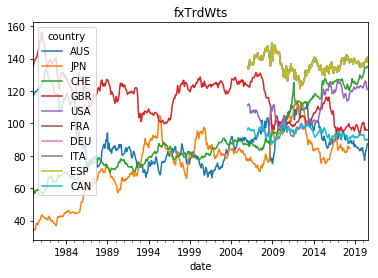

In [120]:

###### Extrapolate for the Euro Area (FRA, ITA, ESP, DEU) and for Canada (CAN) which don't have fxTrdWts
###### print(fxVsUSD['USA']) # a proxy for the Euro Area -> 1 EUR gets you ex. 1.16 USD
###### print(fxVsUSD['CAN']) # a proxy for Canada -> 1 USD gets you ex. 1.16 Canadian Dollars
###### The idea behind this is that the largest trading partner of both Canada and the Eurozone is the US,
###### so a proxy for weighting the trade adjusted FX of these countries is to multiply the USD/EUR and USD/CAD conversion
###### with the fxTrdWts['USA']

###### A proxy for fxTrdWts for the Euro Area is the following
###### Multiply the fxTrdWts['USA'] by the fxVsUSD['USA']
###### All countries within the Eurozone will have the same index obviously, but we keep them separate to allow
###### for an easy combination of the various indicators

fxTrdWts['FRA'] = fxTrdWts['USA'].mul(fxVsUSD['USA'])
fxTrdWts['DEU'] = fxTrdWts['USA'].mul(fxVsUSD['USA'])
fxTrdWts['ITA'] = fxTrdWts['USA'].mul(fxVsUSD['USA'])
fxTrdWts['ESP'] = fxTrdWts['USA'].mul(fxVsUSD['USA'])

fxTrdWts['CAN'] = fxTrdWts['USA'].div(fxVsUSD['CAN'])


fxTrdWts.plot()
plt.title('fxTrdWts')
plt.show()


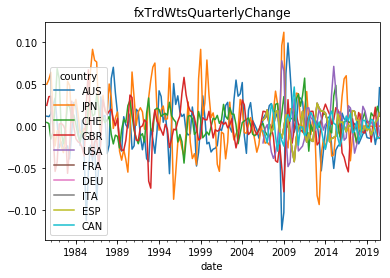

In [121]:
###### Resample to get Quarterly results
fxTrdWtsQuarterly = fxTrdWts.resample('1Q').mean()
fxTrdWtsQuarterlyLastSixMonths = fxTrdWtsQuarterly.rolling(2).mean()

###### Create the 1 Quarter FX change
fxTrdWtsQuarterlyChange = fxTrdWtsQuarterlyLastSixMonths.pct_change()[1:]

fxTrdWtsQuarterlyChange.plot()
plt.title('fxTrdWtsQuarterlyChange')
plt.show()


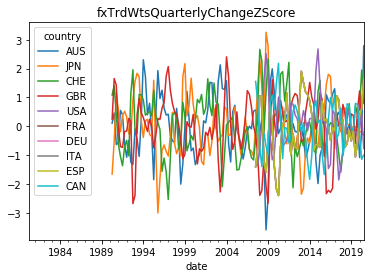

In [159]:

# fxTrdWtsQuarterlyChangeZScore = (fxTrdWtsQuarterlyChange - fxTrdWtsQuarterlyChange.mean())/fxTrdWtsQuarterlyChange.std()
fxTrdWtsQuarterlyChangeZScore = (fxTrdWtsQuarterlyChange - fxTrdWtsQuarterlyChange.rolling(window = 20, min_periods = 5).mean())/fxTrdWtsQuarterlyChange.rolling(window = 20, min_periods = 5).std()

z = fxTrdWtsQuarterlyChangeZScore.loc[pd.Period('1980Q1'):pd.Period('1990Q1'), :]
fxTrdWtsQuarterlyChangeZScore.loc[pd.Period('1980Q1'):pd.Period('1990Q1'), :] = pd.DataFrame(index = z.index, columns = z.columns)

# print('fxTrdWtsQuarterlyChangeZScore')
# print(fxTrdWtsQuarterlyChangeZScore)

fxTrdWtsQuarterlyChangeZScore.plot()
plt.title('fxTrdWtsQuarterlyChangeZScore')
plt.show()


In [141]:
###### Create a filter for deciding our FX position
###### There are a lot of hyperparameters that come into play here
def positionFX(x):
    if 0 < x <= 0.5:
        return 25
    elif 0.5 < x <= 1:
        return 45
    elif 1 < x <= 2:
        return 70
    elif x > 2:
        return 100
    elif x == 0:
        return 0
    elif x >= -0.5:
        return -25
    elif x >= -1:
        return -40
    elif x >= -2:
        return -70
    else:
        return -100

signalFX = fxTrdWtsQuarterlyChangeZScore.applymap(lambda x: positionFX(x) if pd.notnull(x) else np.NaN)

# print('signalFX')
# print(signalFX)

signalFX.tail()





country,AUS,JPN,CHE,GBR,USA,FRA,DEU,ITA,ESP,CAN
date,,,,,,,,,,
2019Q3,-25.0,-25.0,45.0,-40.0,-25.0,-70.0,-70.0,-70.0,-70.0,45.0
2019Q4,25.0,-25.0,25.0,45.0,-25.0,-40.0,-40.0,-40.0,-40.0,45.0
2020Q1,-70.0,-25.0,45.0,70.0,-25.0,25.0,25.0,25.0,25.0,-25.0
2020Q2,-25.0,-25.0,70.0,-25.0,25.0,45.0,45.0,45.0,45.0,-70.0
2020Q3,100.0,-25.0,45.0,-25.0,-40.0,70.0,70.0,70.0,70.0,-40.0


In [142]:
RealizedReturnsFX = pd.DataFrame(index = bondRetIdxQuarterlyReturns.index, columns = bondRetIdxQuarterlyReturns.columns)


for date_index in range(len(RealizedReturnsFX.index) - 1):
    for country in RealizedReturnsFX.columns:
        RealizedReturnsFX[country].iloc[date_index + 1] = signalFX[country].iloc[date_index] * bondRetIdxQuarterlyReturns[country].iloc[date_index + 1]

    
TotalHistoricalRealizedReturnsFX = RealizedReturnsFX.expanding(1).sum()

print('Total P&L = ', TotalHistoricalRealizedReturnsFX.iloc[-1, :].sum())


Total P&L =  -34.72726603482467


In [143]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
##### Analysis of the Strategy
OverallPerformanceFX = pd.DataFrame(index = RealizedReturnsFX.index, columns = ['Total P&L', 'Total Money Invested', 'Total Return'])


OverallPerformanceFX['Total P&L'] = RealizedReturnsFX.sum(axis = 1)
OverallPerformanceFX['Total Money Invested'] = signalFX.T.apply(lambda x: abs(x).sum())

for i in range(1, len(OverallPerformanceFX.index)):
    OverallPerformanceFX['Total Return'].iloc[i] = OverallPerformanceFX['Total P&L'].iloc[i] / OverallPerformanceRealgdpPassiveLong['Total Money Invested'].iloc[i-1]

# print('OverallPerformanceFX')
# print(OverallPerformanceFX)



/Users/dimitral/.local/share/virtualenvs/Internship2020-_YMBLlpf/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [144]:
###### Compute the Risk Adjusted Returns
print('Historical Risk Adjusted Return of the FX Strategy Global Portfolio')
print(OverallPerformanceFX['Total Return'].mean() / OverallPerformanceFX['Total Return'].std())

Historical Risk Adjusted Return of the FX Strategy Global Portfolio
-0.05580172423292181


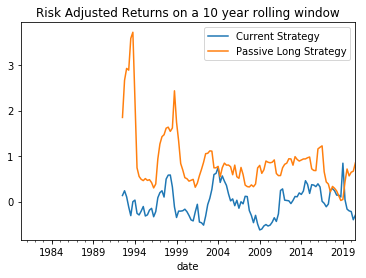

Latest 10 year rolling risk adjusted return for the Current FX Strategy =  -0.2987273410612564
Latest 10 year rolling risk adjusted return for the Passive Long Strategy =  0.850329941797396


In [145]:
###### Create the graphs for rolling 10 year Risk Adjusted Returns
Rolling10YearRiskAdjustedReturnFX = pd.DataFrame(index = OverallPerformanceFX.index, columns = ['Current Strategy', 'Passive Long Strategy'])

Rolling10YearRiskAdjustedReturnFX['Current Strategy'] = OverallPerformanceFX['Total Return'].rolling(10).mean() / OverallPerformanceFX['Total Return'].rolling(10).std()
Rolling10YearRiskAdjustedReturnFX['Passive Long Strategy'] = OverallPerformanceRealgdpPassiveLong['Total Return'].rolling(10).mean() / OverallPerformanceRealgdpPassiveLong['Total Return'].rolling(10).std()


Rolling10YearRiskAdjustedReturnFX.plot()
plt.title('Risk Adjusted Returns on a 10 year rolling window')
plt.show()

print('Latest 10 year rolling risk adjusted return for the Current FX Strategy = ', Rolling10YearRiskAdjustedReturnFX['Current Strategy'][-1])
print('Latest 10 year rolling risk adjusted return for the Passive Long Strategy = ', Rolling10YearRiskAdjustedReturnFX['Passive Long Strategy'][-1])


Pearson Correlation of current and passive strategy returns
                       Current Strategy  Passive Long Strategy
Current Strategy               1.000000              -0.018343
Passive Long Strategy         -0.018343               1.000000


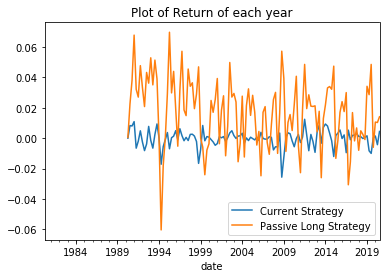

In [146]:
##################################################################################################################
##### Correlations
CorrelationReturnFX = pd.DataFrame({'Current Strategy': OverallPerformanceFX['Total Return'],
                                    'Passive Long Strategy': OverallPerformanceRealgdpPassiveLong['Total Return']},
                                           index = OverallPerformanceFX.index)


print('Pearson Correlation of current and passive strategy returns')
print(CorrelationReturnFX.astype(float).corr(method = 'pearson'))

# From these graphs we can see that the current FX method is less volatile than the Passive Long Method
CorrelationReturnFX.plot()
plt.title('Plot of Return of each year')
plt.show()


country                  AUS     JPN     CHE     GBR     USA     FRA     DEU  \
Sum of Signal Values  5420.0  5115.0  5620.0  5410.0  2220.0  2420.0  2420.0   

country                  ITA     ESP     CAN  
Sum of Signal Values  2420.0  2420.0  2360.0  


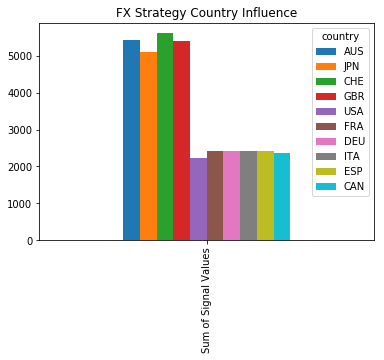

In [147]:
###### Sanity Check to see whether any one country dominates the index
###### For each country we sum up the absolute values of the Signal

StrategySignalperCountryFX = pd.DataFrame(index = ['Sum of Signal Values'], columns = signalFX.columns)

for country in signalFX.columns:
    StrategySignalperCountryFX[country] = abs(signalFX[country]).sum()

print(StrategySignalperCountryFX)
StrategySignalperCountryFX.plot.bar()
plt.title('FX Strategy Country Influence')
plt.show()


In [148]:
###### Lets us take a deeper dive into the reasons behind this discrepancy in the signal strength between
###### the USA, CAN, FRA, DEU, ESP, ITA and AUS, JPN, CHE, GBR, which seem to dominate the signal.
###### Obviously the first group were all contructed from the base signal of the USA, while the second 
###### group had its own data.
print(signalFX)

country    AUS    JPN   CHE    GBR    USA   FRA   DEU   ITA   ESP   CAN
date                                                                   
1980Q2     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1980Q3     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1980Q4     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1981Q1     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1981Q2     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1981Q3     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1981Q4     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1982Q1     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1982Q2     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1982Q3     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1982Q4     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN
1983Q1     NaN    NaN   NaN    NaN    NaN   NaN   NaN   NaN   Na

country                    AUS       JPN        CHE        GBR        USA  \
Sum of Signal Values  44.42623  41.92623  46.065574  44.344262  41.886792   

country                     FRA        DEU        ITA        ESP        CAN  
Sum of Signal Values  45.660377  45.660377  45.660377  45.660377  44.528302  


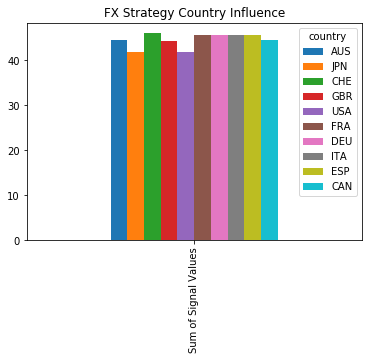

In [149]:
###### This seems to be the case because we have way fewer historical datapoints for the first group
###### Now let us normalize our counting method by the number of times a country actually has data available
###### for it at a specific point in time.

StrategySignalperCountryFXNormalized = pd.DataFrame(index = ['Sum of Signal Values'], columns = signalFX.columns)

for country in signalFX.columns:
    StrategySignalperCountryFXNormalized[country] = abs(signalFX[country]).sum() / signalFX[country].count()

print(StrategySignalperCountryFXNormalized)
StrategySignalperCountryFXNormalized.plot.bar()
plt.title('FX Strategy Country Influence')
plt.show()

Now things look more normal than they did before

In [150]:
############################################################################################################
############################################################################################################
############################################################################################################
###### Combine the 2 Signals

# signalRealGDP and signalWeightedRealGDP and signalFX

a = 0.7
b = 0.3

signalOverall = a * (signalRealGDP + signalWeightedRealGDP) / 2 + b * signalFX
# print(signalOverall)

In [151]:
RealizedReturnsOverall = pd.DataFrame(index = bondRetIdxQuarterlyReturns.index, columns = bondRetIdxQuarterlyReturns.columns)


for date_index in range(len(RealizedReturnsOverall.index) - 1):
    for country in RealizedReturnsOverall.columns:
        RealizedReturnsOverall[country].iloc[date_index + 1] = signalOverall[country].iloc[date_index] * bondRetIdxQuarterlyReturns[country].iloc[date_index + 1]

    
TotalHistoricalRealizedReturnsOverall = RealizedReturnsOverall.expanding(1).sum()

print('Total P&L = ', TotalHistoricalRealizedReturnsOverall.iloc[-1, :].sum())


Total P&L =  12.260322534593444


In [152]:
##################################################################################################################
##################################################################################################################
##################################################################################################################
##### Analysis of the Strategy
OverallPerformance = pd.DataFrame(index = RealizedReturnsOverall.index, columns = ['Total P&L', 'Total Money Invested', 'Total Return'])


OverallPerformance['Total P&L'] = RealizedReturnsOverall.sum(axis = 1)
OverallPerformance['Total Money Invested'] = signalOverall.T.apply(lambda x: abs(x).sum())

for i in range(1, len(OverallPerformanceFX.index)):
    OverallPerformance['Total Return'].iloc[i] = OverallPerformance['Total P&L'].iloc[i] / OverallPerformanceRealgdpPassiveLong['Total Money Invested'].iloc[i-1]

# print('OverallPerformance')
# print(OverallPerformance)

/Users/dimitral/.local/share/virtualenvs/Internship2020-_YMBLlpf/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [153]:
###### Compute the Risk Adjusted Returns
print('Risk Adjusted Return of the Overall Strategy Portfolio')
print(OverallPerformance['Total Return'].mean() / OverallPerformance['Total Return'].std())

Risk Adjusted Return of the Overall Strategy Portfolio
0.05263448765086445


In [154]:
###### Compare it with the Passive Long Portfolio
print('Risk Adjusted Return of the Passive Long Portfolio')
print(OverallPerformanceRealgdpPassiveLong['Total Return'].mean() / OverallPerformanceRealgdpPassiveLong['Total Return'].std())


Risk Adjusted Return of the Passive Long Portfolio
0.7776299985230405


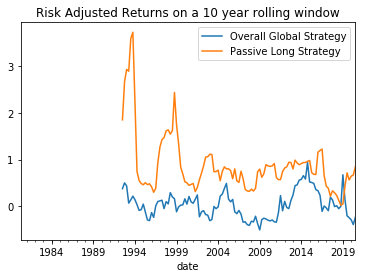

Latest 10 year rolling risk adjusted return for the Overall Global Strategy =  -0.23403808198474124
Latest 10 year rolling risk adjusted return for the Passive Long Strategy =  0.850329941797396


In [155]:
###### Create the graphs for rolling 10 year Risk Adjusted Returns
Rolling10YearRiskAdjustedReturnOverall = pd.DataFrame(index = OverallPerformance.index, columns = ['Overall Global Strategy', 'Passive Long Strategy'])

Rolling10YearRiskAdjustedReturnOverall['Overall Global Strategy'] = OverallPerformance['Total Return'].rolling(10).mean() / OverallPerformance['Total Return'].rolling(10).std()
Rolling10YearRiskAdjustedReturnOverall['Passive Long Strategy'] = OverallPerformanceRealgdpPassiveLong['Total Return'].rolling(10).mean() / OverallPerformanceRealgdpPassiveLong['Total Return'].rolling(10).std()


Rolling10YearRiskAdjustedReturnOverall.plot()
plt.title('Risk Adjusted Returns on a 10 year rolling window')
plt.show()

print('Latest 10 year rolling risk adjusted return for the Overall Global Strategy = ', Rolling10YearRiskAdjustedReturnOverall['Overall Global Strategy'][-1])
print('Latest 10 year rolling risk adjusted return for the Passive Long Strategy = ', Rolling10YearRiskAdjustedReturnOverall['Passive Long Strategy'][-1])




Pearson Correlation of Overall Global Strategy and Passive Long Strategy
                         Overall Global Strategy  Passive Long Strategy
Overall Global Strategy                 1.000000              -0.133343
Passive Long Strategy                  -0.133343               1.000000


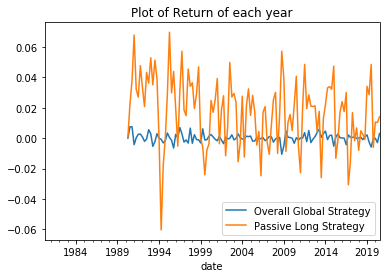

In [156]:
##################################################################################################################
##### Correlations
CorrelationReturnOverall = pd.DataFrame({'Overall Global Strategy': OverallPerformance['Total Return'],
                                    'Passive Long Strategy': OverallPerformanceRealgdpPassiveLong['Total Return']},
                                           index = OverallPerformanceFX.index)


print('Pearson Correlation of Overall Global Strategy and Passive Long Strategy')
print(CorrelationReturnOverall.astype(float).corr(method = 'pearson'))

# From these graphs we can see that the Overall Strategy is less volatile than the Passive Long Strategy
CorrelationReturnOverall.plot()
plt.title('Plot of Return of each year')
plt.show()


country                     AUS        CAN       CHE        DEU        ESP  \
Sum of Signal Values  28.930328  27.283019  28.22541  24.641509  31.726415   

country                     FRA        GBR        ITA        JPN        USA  
Sum of Signal Values  20.886792  27.473361  21.278302  29.038934  22.070755  


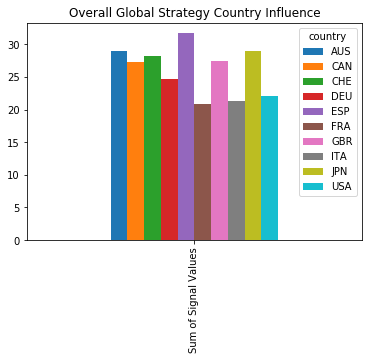

In [157]:
StrategySignalperCountryOverallNormalized = pd.DataFrame(index = ['Sum of Signal Values'], columns = signalOverall.columns)

for country in signalOverall.columns:
    StrategySignalperCountryOverallNormalized[country] = abs(signalOverall[country]).sum() / signalOverall[country].count()

print(StrategySignalperCountryOverallNormalized)
StrategySignalperCountryOverallNormalized.plot.bar()
plt.title('Overall Global Strategy Country Influence')
plt.show()

In [158]:
###### Invert the past history and see what happens in an environment of rising interest rates and falling bond returns
bondRetIdxQuarterlyReturnsReversed = bondRetIdxQuarterlyReturns[::-1]



